In [41]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression



In [42]:
#data
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

**Part One: Fitting Models**

This section asks you to create a final best model for each of the model types studied this week. For each, you should:

* Find the best model based on ROC AUC for predicting the target variable.

* Report the (cross-validated!) ROC AUC metric.

* Fit the final model.

* Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.

* (Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.

**Q1: KNN**

In [43]:
#variable selection
X = ha.drop(["output", "chol"], axis = 1)
y = ha["output"]

In [44]:
#column transformer
ct = ColumnTransformer(
  [
    #drop = "first" should make it so that division is not included in the model
    ("dummify", OneHotEncoder(sparse_output = False, drop = "first"), ["cp", "sex", "restecg"]),
    ("standardize", StandardScaler(), ["age", "trtbps", "thalach"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

#interaction
# ColumnTransformer for interactions only
ct_inter = ColumnTransformer(
    [
    ("interaction_CRuns_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__age", "dummify__sex_1"]),
    #("interaction_PutOuts_Division", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__PutOuts", "dummify__Division_W"]),
    ],
    remainder="passthrough"
)

#get col names
X_1 = ct.fit_transform(X)
#X_1

In [45]:
#kNN model pipeline
knn_pipeline = Pipeline([
    ("preprocessing", ct),
    ("interaction", ct_inter),
    #set to be n_neigbors =7 b/c that is the highest accuracy score from tuning
    ("knn_classifier", KNeighborsClassifier(n_neighbors=7))
]).set_output(transform = "pandas")

In [46]:
#tuning KNN to find best k val
ks = {"knn_classifier__n_neighbors": list(range(1, 26))}

gscv = GridSearchCV(knn_pipeline, ks, cv = 5, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

,knn_classifier__n_neighbors,scores
6,7,0.835494
12,13,0.830142
7,8,0.829704
8,9,0.829001
10,11,0.828686


For each model included below, they were tuned n_neighbors and then optimized accuracy score is reported below (please note that only models that are found to have a higher ROC AUC score will be shown below):

1. model including every predictor 0.787

2. model with every predictor except chol: 0.828

3. model with every predictor except chol AND interaction effect between sex and age: 0.835 (BEST MODEL, this is what will be used and the code for it is above)

In [47]:
#split data

#split to train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#fit data using final model
knn_pipeline.fit(X, y)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['cp', 'sex', 'restecg']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['age', 'trtbps',
                                                   'thalach'])])),
                ('interaction',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('interaction_CRuns_Division',
                                                  PolynomialFeatures(include_bias=False,
                                                                     interaction_only=True),
                                                  ['standardize__age',
                                                   'dummify__sex_1'])])),
                ('knn_classifier', KNeighborsClassifier(n_neighbors=7))])

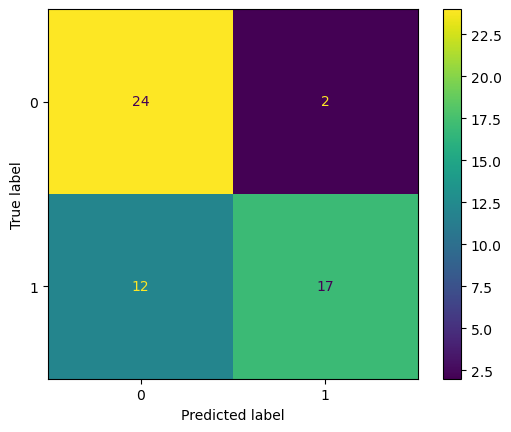

In [48]:
#get confusion matrix

# predict y's on X_test
y_pred = knn_pipeline.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_pipeline.named_steps['knn_classifier'].classes_)
disp.plot()

**No Coef. Needed?**

**Q2: Logistic Regression**

In [49]:
#variable selection
X = ha.drop(["output", "age"], axis = 1)
y = ha["output"]

In [50]:
#column transformer
ct = ColumnTransformer(
  [
    #drop = "first" should make it so that division is not included in the model
    ("dummify", OneHotEncoder(sparse_output = False, drop = "first"), ["sex", "cp", "restecg"]),
    ("standardize", StandardScaler(), ["trtbps", "thalach", "chol"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

#interaction
# ColumnTransformer for interactions only
ct_inter = ColumnTransformer(
    [
    ("interaction_1", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__trtbps", "dummify__cp_1"]),
    ],
    remainder="passthrough"
)

#get col names
X_1 = ct.fit_transform(X)
#X_1

In [51]:
#logistic model pipeline
logistic_pipeline = Pipeline([
    ("preprocessing", ct),
    ("interaction", ct_inter),
    #assuming that we dont need to tune logistic regression?
    ("logistic_regression", LogisticRegression())
]).set_output(transform = "pandas")

#some penalizing parameter

In [52]:
#crossval score using roc auc
scores = cross_val_score(logistic_pipeline, X, y, cv=5, scoring='roc_auc')
roc_auc = scores.mean()
roc_auc

0.8673987621573829

For each model included below please note that only models that are found to have a higher ROC AUC score will be shown below:

1. model including every predictor: .8635

2. model including every predictor EXCEPT age: .8668

3. model including every predictor EXCEPT age AND interaction effect between trtbps and cp: .8673

In [53]:
#split to train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#fit data using final model
logistic_pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['sex', 'cp', 'restecg']),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  ['trtbps', 'thalach',
                                                   'chol'])])),
                ('interaction',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('interaction_1',
                                                  PolynomialFeatures(include_bias=False,
                                                                     interaction_only=True),
                                                  ['standardize__trtbps',
                                                   'dummify__cp_1'])])),
                ('logistic_regression', LogisticRegression())])

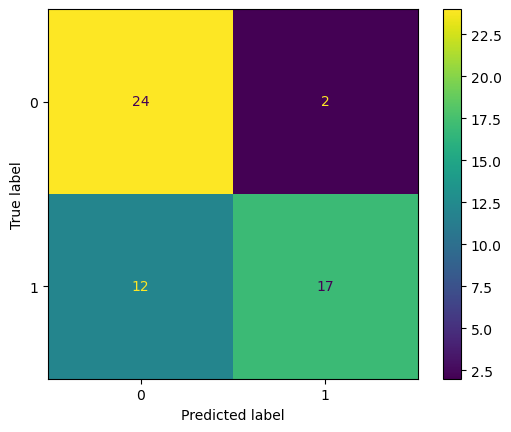

In [54]:
#confusion matrix
#get confusion matrix

# predict y's on X_test
y_pred = logistic_pipeline.predict(X_test)

# generate confusion matrix
confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_pipeline.named_steps['logistic_regression'].classes_)
disp.plot()

In [56]:
#COPIED FROM CHATGPT NEED TO LOOK OVER

# Extract the logistic regression model after fitting
model = logistic_pipeline.named_steps["logistic_regression"]

# Get the transformed feature names from the ColumnTransformer
feature_names = ct.get_feature_names_out()

# Check if interaction terms are included, and update feature names
if "interaction" in logistic_pipeline.named_steps:
    feature_names = logistic_pipeline.named_steps["interaction"].get_feature_names_out(feature_names)

# Get the coefficients and intercept
coefficients = model.coef_.flatten()

# Combine feature names and coefficients into a DataFrame
import pandas as pd
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})

# Display the coefficients with feature names
print(coef_df)


                                            Feature  Coefficient
0                interaction_1__standardize__trtbps    -0.281307
1                      interaction_1__dummify__cp_1     1.636028
2  interaction_1__standardize__trtbps dummify__cp_1    -0.488845
3                         remainder__dummify__sex_1    -1.745813
4                          remainder__dummify__cp_2     1.597345
5                          remainder__dummify__cp_3     1.184080
6                     remainder__dummify__restecg_1     0.312870
7                     remainder__dummify__restecg_2    -0.270366
8                   remainder__standardize__thalach     0.862760
9                      remainder__standardize__chol    -0.293133
                                            Feature  Coefficient
0                interaction_1__standardize__trtbps    -0.281307
1                      interaction_1__dummify__cp_1     1.636028
2  interaction_1__standardize__trtbps dummify__cp_1    -0.488845
3                        

Some key coefficients that we observed in our model with their corresponding interpretation:

cp_1: 1.64 -> if the chest pain type is 1, the log-odds of being at risk of a heart attack increases by 1.64 when comparing to those with chest pain type = 4 (while holding everything else constant)

cp_1 and trtbps interaction: -0.48 -> the combined effect of resting blood pressure (standardized) and chest pain type 1 is assocaited with a .48 decrease in log odds of being at risk of a heart attack.

(1 = male, 0 = female)
sex: -1.74 -> if individual is male, the log odds of being at risk of a hearth attack decreases by 1.74 when compared to females

thalach: .8627 -> For every one-unit increase in standardized maximum heart rate achieved during excersize, the log-odds of being at risk increase by 0.86.

**Q3: Decision Tree**

In [57]:
#variable selection
X = ha.drop(["output", "age"], axis = 1)
y = ha["output"]

In [58]:
#column transformer
ct = ColumnTransformer(
  [
    #drop = "first" should make it so that division is not included in the model
    ("dummify", OneHotEncoder(sparse_output = False, drop = "first"), ["sex", "cp", "restecg"]),
    ("standardize", StandardScaler(), ["trtbps", "thalach", "chol"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

#interaction
# ColumnTransformer for interactions only
ct_inter = ColumnTransformer(
    [
    ("interaction_1", PolynomialFeatures(degree=2, interaction_only = True, include_bias=False), ["standardize__trtbps", "dummify__cp_1"]),
    ],
    remainder="passthrough"
)

#get col names
X_1 = ct.fit_transform(X)
#X_1

In [59]:
#decision tree pipeline
decision_tree_pipeline = Pipeline([
    ("preprocessing", ct),
    ("interaction", ct_inter),
    #assuming that we dont need to tune logistic regression?
    ("decision_tree_classifier", DecisionTreeClassifier())
]).set_output(transform = "pandas")

#tune using ccp_alpha

In [60]:
#crossval score using roc auc
scores = cross_val_score(decision_tree_pipeline, X, y, cv=5, scoring='roc_auc')
roc_auc = scores.mean()
roc_auc

0.6683465959328029

**Q4: Interpretation**

Which predictors were most important to predicting heart attack risk?

**Q5: ROC Curve**

Plot the ROC Curve for your three models above.